# Post Earnings Event Study

In this notebook we explore the relationship between the post-earnings EPS surprise and the cumulative residual returns in the days following an earnings event. 

**Conclusions:**

* There is a positive cumulative residual return when the EPS surprise is positive and vice versa
* Negative earnings surprises tend to produce a larger negative return than positive surprises
* After day 1, negative earnings surprises show a reversal in cummulative residual returns from negative to positive
* Estimze EPS deltas produced more alpha following an event than the Wall Street EPS deltas
* Sector analysis showed most sectors produced strong alpha with the exception of Consumer Staples, Healthcare and Utilities
* Market Cap analysis showed that Small and Mid Cap stocks produced the strongest alpha

## Data and Methodology

**Datasources:**

* EPS Consensus values (Estimize consensuses.csv)
* Asset historical prices (Zipline.io/Quandl prices dataset)
* SPY historical prices (Yahoo Finance)

Our first step is to generate the actual and Estimize weighted EPS deltas for each release:

$$EPSDelta = \frac{EPS_{actual} - EPS_{estimize}}{STDEV_{estimize} + 0.01}$$

Where $STDEV_{estimize}$ is the standard deviation of the release's estimize consensus.

After calculating the EPS deltas for all reported releases, we group them by quantile, with 1 being the lowest and 5 being the highest. This set of data represents the events we will plug into the event study.

The next step is to get the residual returns for each stock following an event. We calculate the residual returns using the CAPM with S&P500 index as the market portfolio:

$$E(R_{i,t})=b_0 + b_1 \cdot E(R_{M,t})$$

,

$$ResidualReturn_{i,t}=R_{i,t} - E(R_{i,t})$$

Usually returns are calculated from closing prices, however, due to the nature of earnings events, we are calculating using the open-to-open prices. If we didn't do this, we would be grouping the over-night returns and the intra-day returns into one event interval.

Finally, we take the cumulative residual returns over the days in the event study grouped by the EPS delta quantile.

**Disclaimer:**

This event study was prepared in a fashion similar to other event studies and research done in this field. Since the decile calculations are done ex-post, it should be noted that any trading strategy using this factor should calculate the eps delta deciles in a rolling fashion.

In [5]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, AssetInfoService, CalendarService,
    EstimizeConsensusService, EventStudyService, MarketCapService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
asset_service = injector.get(AssetService)
calendar_service = injector.get(CalendarService)
estimize_consensus_service = injector.get(EstimizeConsensusService)


In [6]:
DEFAULT_START_DATE = '2012-01-01'
DEFAULT_END_DATE = '2019-01-01'

def plot_results(df):
    """
    Plots cumulative residual returns based on decile.
    
    Parameters
    ----------
    df : pd.DataFrame
    """
    df = df.reset_index()
    df.set_index('event_time', inplace=True)
    
    plt.figure(figsize=(16, 10))
    
    quantiles = list(df['quantile'].astype('int').unique())
    quantiles.reverse()
    
    cm = plt.get_cmap('jet_r') 
    c_norm  = colors.Normalize(vmin=quantiles[-1], vmax=quantiles[0])
    scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cm)
    
    for quantile in quantiles:
        if quantile == quantiles[0] or quantile == quantiles[-1]:
            linewidth = 2.0
        else:
            linewidth = 1.0
            
        color = scalar_map.to_rgba(quantile)
            
        ddf = df.loc[df['quantile'] == quantile, 'cumulative_residual_return']
        ddf -= ddf.iloc[0]
        ddf *= 100.0
        ddf.plot(xticks=range(0, 21), label=quantile, linewidth=linewidth, color=color)
        
    plt.plot([0 for _ in range(0, 21)], 'r--')
    
    plt.ylabel("% Cumulative Residual Return")
    plt.xlabel("Event Time")
    plt.gca().grid(True)
    plt.legend(title='Quantile', loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

def display_table(df):
    df = df.reset_index()

    df = pd.pivot_table(df, values='cumulative_residual_return', index='quantile', columns=['event_time'])
    df *= 100
    df = df.subtract(df[0], axis='index')
    df = df[[1, 2, 3, 4, 5, 10, 15, 20]]
    df = df.applymap("{0:.2f}%".format)
    display(df)

def display_results(es, title=None):
    df, events = es
    num_events = df.loc[df.index.get_level_values('event_time') == 0, 'count'].sum()
    
    if title is not None:
        display(Markdown('### {}'.format(title)))
        
    print('Num Events: {:,}'.format(num_events))
    
    plot_results(df)
    display_table(df)

def filter(df, column, value):
    return df[dfutils.column_values(df, column) == value]

def fix_index(df):
    def fix_row_index(row):
        index = row[0]
        cols = row[1]
        date = index[0]
        asset = index[1]

        if cols['bmo']:
            date = date - timedelta(days=1)

        date = calendar_service.get_valid_trading_end_date(date)

        return date, asset

    df.index = pd.MultiIndex.from_tuples(list(map(fix_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']

def get_eps_deltas(start_date, end_date, population='estimize'):
    if population == 'estimize':
        eps_column = 'estimize.eps.weighted'
    elif population == 'wallstreet':
        eps_column = 'wallstreet.eps'
    else:
        raise ValueError('Unkown population: {}'.format(population))
    
    df = estimize_consensus_service.get_final_consensuses(start_date, end_date)
#     df['eps_delta'] = (df['actual.eps'] - df[eps_column]) / (np.abs(df[eps_column]) + 0.01)
    df['eps_delta'] = (df['actual.eps'] - df[eps_column]) / (df['estimize.eps.sd'] + 0.01)
    df = df[['bmo', 'eps_delta']]
    df.dropna(inplace=True)
    fix_index(df)
    df.drop(['bmo'], axis=1, inplace=True)
    
    return df

def get_post_earnings_events(start_date, end_date, population='estimize'):
    df = get_eps_deltas(start_date, end_date, population)
    
    # Filter on universe
    udf = asset_service.get_universe(start_date, end_date)
    df = df.join(udf, how='inner')
    
    # Add quantile
    df['quantile'] = pd.qcut(df['eps_delta'].values, 5, labels=False) + 1
    df.drop(['eps_delta'], axis=1, inplace=True)
    
    return df

def run_event_study(start_date, end_date, join_fn=None, population='estimize'):
    event_study_service = injector.get(EventStudyService)
    events = get_post_earnings_events(start_date, end_date, population)
    
    if join_fn is not None:
        events = join_fn(start_date, end_date, events)
    
    df = event_study_service.run_event_study(
        events=events,
        on='open',
        days_before=0,
        days_after=20
    )
    
    return (df, events)

def join_sectors(start_date, end_date, events):
    asset_info_service = injector.get(AssetInfoService)
    df = asset_info_service.get_asset_info()['sector']

    events.reset_index(inplace=True)
    events.set_index('asset', inplace=True)
    events = events.join(df, how='inner')

    events.reset_index(inplace=True)
    events.set_index(['as_of_date', 'asset'], inplace=True)

    return events

def join_market_caps(start_date, end_date, events):
    market_cap_service = injector.get(MarketCapService)
    assets = dfutils.unique_assets(events)
    df = market_cap_service.get_market_caps(start_date, end_date, assets)['market_cap_type']
    df.rename({'market_cap_type': 'market_cap'}, inplace=True)

    events = events.join(df, how='inner')

    return events


## EPS Deltas

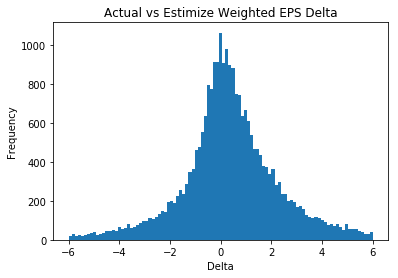

In [7]:
edf = get_eps_deltas(DEFAULT_START_DATE, DEFAULT_END_DATE)['eps_delta']

bins = np.linspace(-6, 6, 100)
plt.hist(edf, bins)
plt.title("Actual vs Estimize Weighted EPS Delta")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()


In [8]:
# Run all-time event study with wallstreet estimates

es_ws_alltime = run_event_study(DEFAULT_START_DATE, DEFAULT_END_DATE, population='wallstreet')


### All Stocks (All-time using WS EPS delta)

Num Events: 24,311


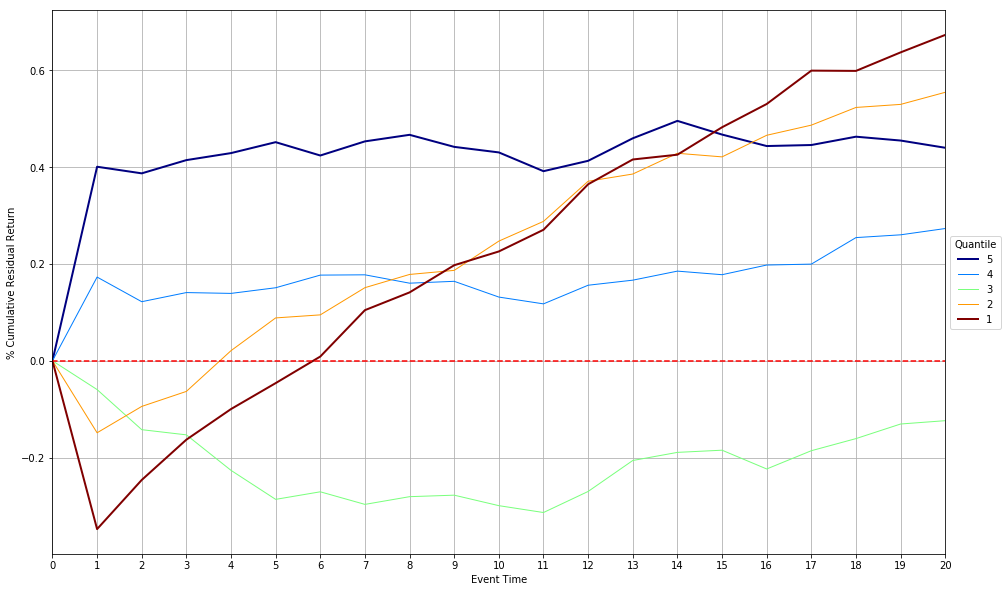

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.35%,-0.25%,-0.16%,-0.10%,-0.05%,0.23%,0.48%,0.67%
2.0,-0.15%,-0.09%,-0.06%,0.02%,0.09%,0.25%,0.42%,0.55%
3.0,-0.06%,-0.14%,-0.15%,-0.23%,-0.29%,-0.30%,-0.18%,-0.12%
4.0,0.17%,0.12%,0.14%,0.14%,0.15%,0.13%,0.18%,0.27%
5.0,0.40%,0.39%,0.41%,0.43%,0.45%,0.43%,0.47%,0.44%


In [9]:
display_results(es_ws_alltime, 'All Stocks (All-time using WS EPS delta)')

In [10]:
# Run all-time event study

es_alltime = run_event_study(DEFAULT_START_DATE, DEFAULT_END_DATE)


### All Stocks (All-time using default Estimize EPS delta)

Num Events: 25,187


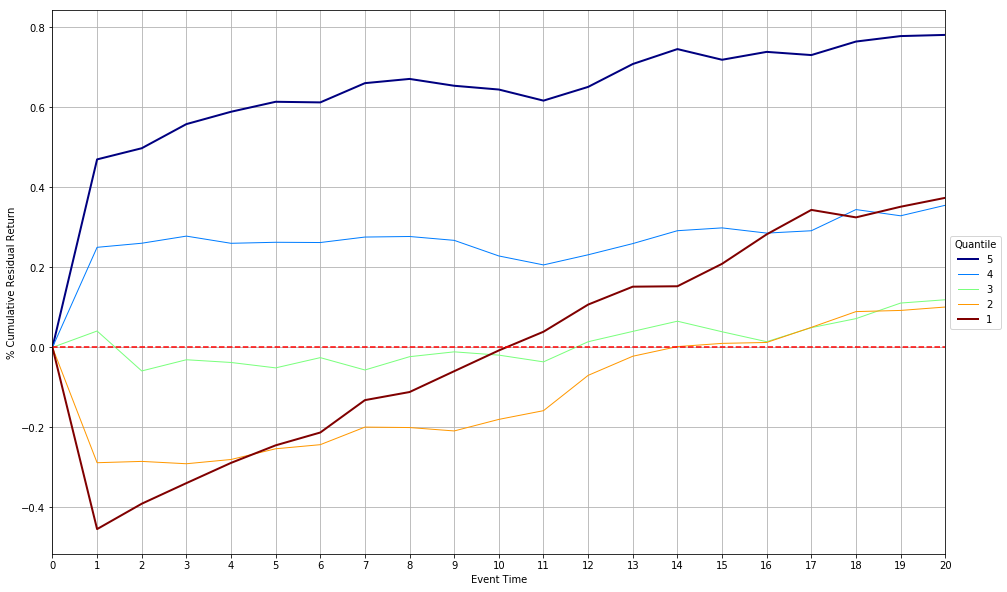

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.45%,-0.39%,-0.34%,-0.29%,-0.24%,-0.01%,0.21%,0.37%
2.0,-0.29%,-0.29%,-0.29%,-0.28%,-0.25%,-0.18%,0.01%,0.10%
3.0,0.04%,-0.06%,-0.03%,-0.04%,-0.05%,-0.02%,0.04%,0.12%
4.0,0.25%,0.26%,0.28%,0.26%,0.26%,0.23%,0.30%,0.36%
5.0,0.47%,0.50%,0.56%,0.59%,0.61%,0.64%,0.72%,0.78%


In [11]:
display_results(es_alltime, 'All Stocks (All-time using default Estimize EPS delta)')

In [12]:
# Run 2018 event study

start_date = '2018-01-01'
end_date = '2019-01-01'

es2018 = run_event_study(start_date, end_date)

### All Stocks (up to Q1 2018)

Num Events: 1,468


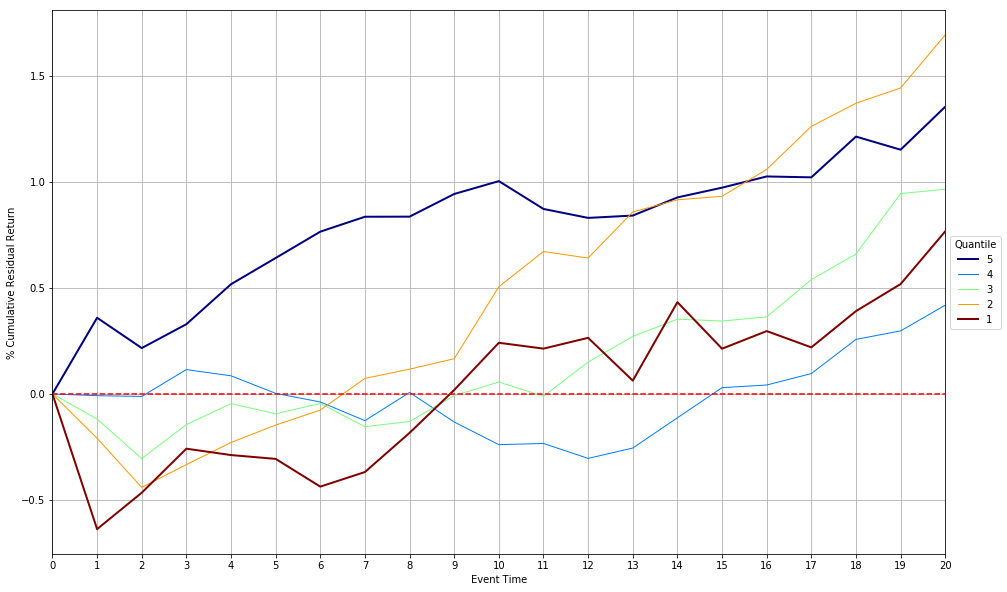

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.64%,-0.47%,-0.26%,-0.29%,-0.31%,0.24%,0.21%,0.77%
2.0,-0.21%,-0.44%,-0.33%,-0.23%,-0.15%,0.51%,0.93%,1.69%
3.0,-0.12%,-0.30%,-0.14%,-0.05%,-0.09%,0.06%,0.34%,0.97%
4.0,-0.01%,-0.01%,0.11%,0.09%,0.00%,-0.24%,0.03%,0.42%
5.0,0.36%,0.22%,0.33%,0.52%,0.64%,1.00%,0.97%,1.35%


In [30]:
display_results(es2018, 'All Stocks (up to Q1 2018)')

In [14]:
# Run 2017 event study

start_date = '2017-01-01'
end_date = '2018-01-01'

es2017 = run_event_study(start_date, end_date)

### All Stocks (2017)

Num Events: 6,075


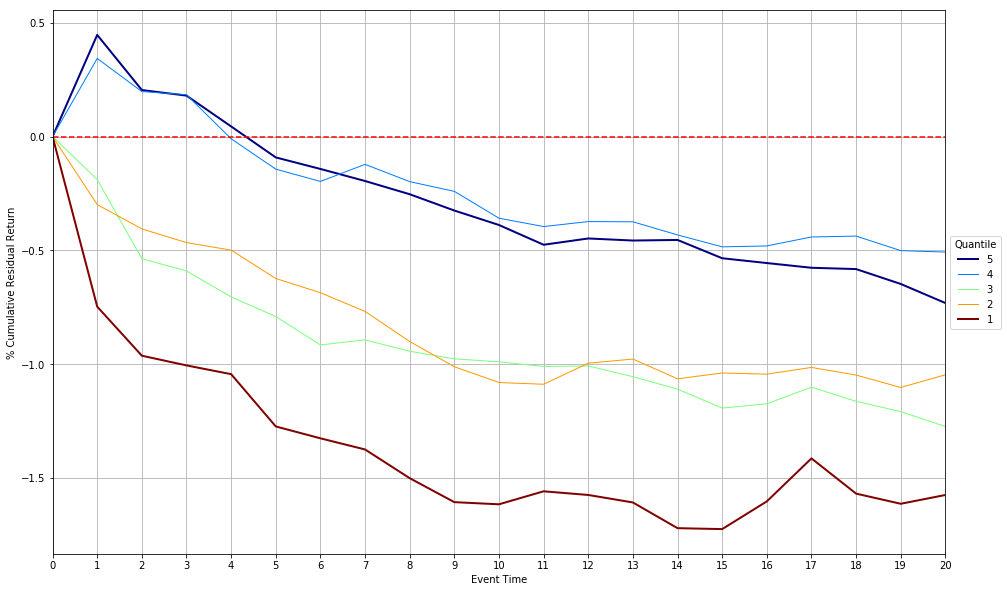

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.75%,-0.96%,-1.01%,-1.04%,-1.27%,-1.62%,-1.72%,-1.57%
2.0,-0.30%,-0.41%,-0.47%,-0.50%,-0.62%,-1.08%,-1.04%,-1.05%
3.0,-0.19%,-0.54%,-0.59%,-0.70%,-0.79%,-0.99%,-1.19%,-1.27%
4.0,0.34%,0.20%,0.18%,-0.01%,-0.14%,-0.36%,-0.48%,-0.51%
5.0,0.45%,0.20%,0.18%,0.04%,-0.09%,-0.39%,-0.53%,-0.73%


In [15]:
display_results(es2017, 'All Stocks (2017)')

In [16]:
# Run 2016 event study

start_date = '2016-01-01'
end_date = '2017-01-01'

es2016 = run_event_study(start_date, end_date)

### All Stocks (2016)

Num Events: 5,877


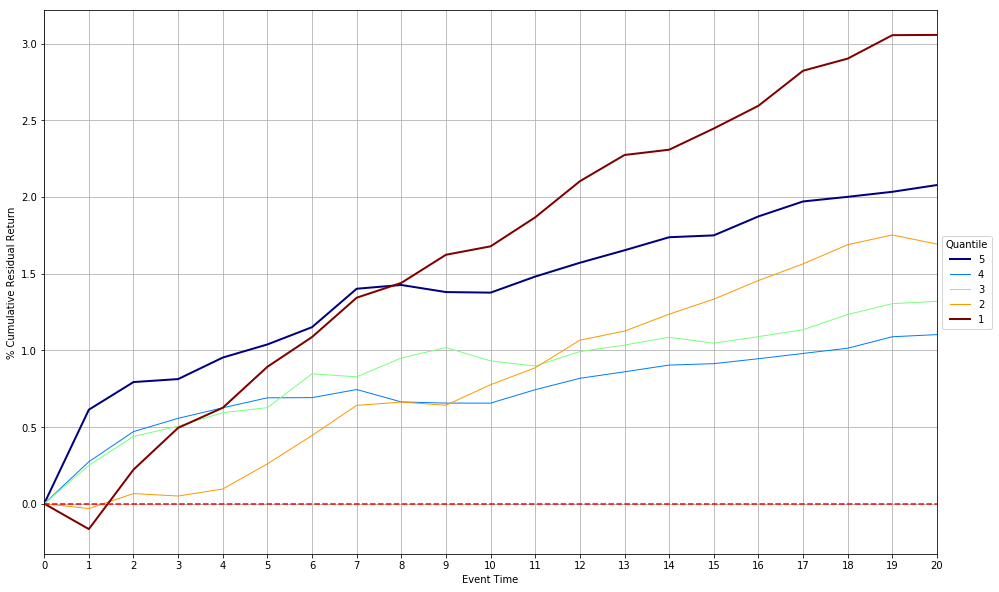

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.17%,0.22%,0.49%,0.63%,0.89%,1.68%,2.45%,3.06%
2.0,-0.03%,0.07%,0.05%,0.10%,0.26%,0.78%,1.33%,1.69%
3.0,0.25%,0.44%,0.51%,0.59%,0.63%,0.93%,1.05%,1.32%
4.0,0.27%,0.47%,0.56%,0.63%,0.69%,0.66%,0.91%,1.10%
5.0,0.61%,0.79%,0.81%,0.95%,1.04%,1.38%,1.75%,2.08%


In [17]:
display_results(es2016, 'All Stocks (2016)')

In [18]:
# Run 2015 event study

start_date = '2015-01-01'
end_date = '2016-01-01'

es2015 = run_event_study(start_date, end_date)

### All Stocks (2015)

Num Events: 4,755


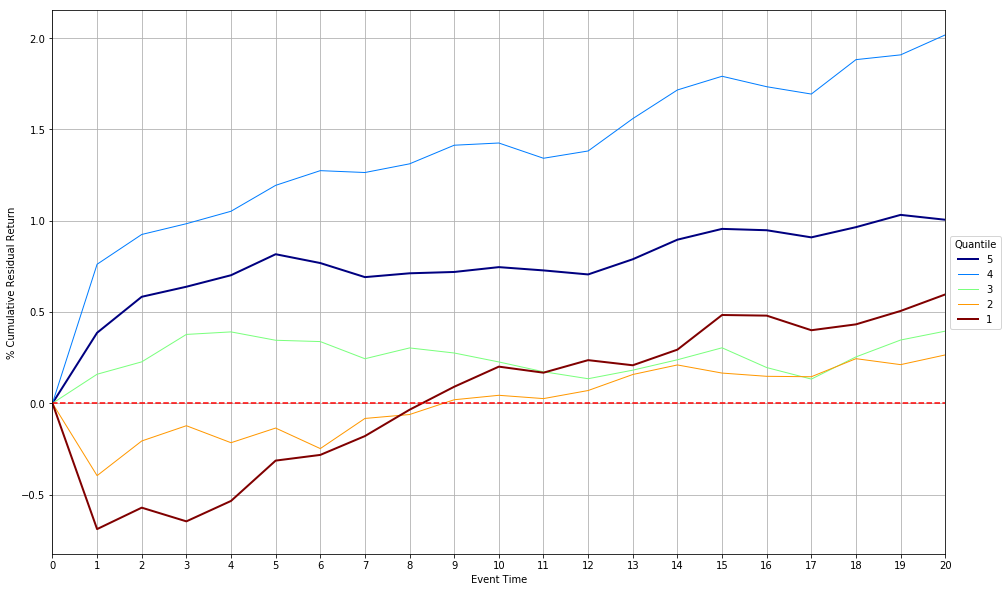

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.69%,-0.57%,-0.65%,-0.53%,-0.31%,0.20%,0.48%,0.60%
2.0,-0.40%,-0.21%,-0.12%,-0.22%,-0.14%,0.04%,0.17%,0.26%
3.0,0.16%,0.23%,0.38%,0.39%,0.35%,0.23%,0.30%,0.40%
4.0,0.76%,0.92%,0.98%,1.05%,1.19%,1.43%,1.79%,2.02%
5.0,0.39%,0.58%,0.64%,0.70%,0.82%,0.75%,0.96%,1.01%


In [19]:
display_results(es2015, 'All Stocks (2015)')

In [20]:
# Run 2014 event study

start_date = '2014-01-01'
end_date = '2015-01-01'

es2014 = run_event_study(start_date, end_date)

### All Stocks (2014)

Num Events: 3,379


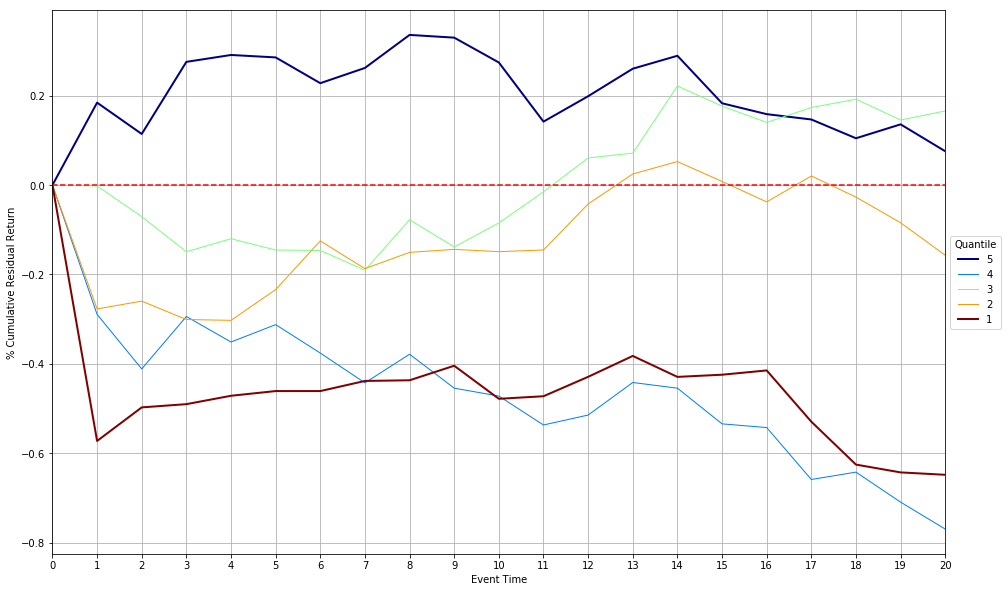

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.57%,-0.50%,-0.49%,-0.47%,-0.46%,-0.48%,-0.42%,-0.65%
2.0,-0.28%,-0.26%,-0.30%,-0.30%,-0.23%,-0.15%,0.01%,-0.16%
3.0,-0.00%,-0.07%,-0.15%,-0.12%,-0.15%,-0.08%,0.18%,0.17%
4.0,-0.29%,-0.41%,-0.29%,-0.35%,-0.31%,-0.47%,-0.53%,-0.77%
5.0,0.18%,0.11%,0.28%,0.29%,0.29%,0.27%,0.18%,0.08%


In [21]:
display_results(es2014, 'All Stocks (2014)')

In [22]:
# Run 2013 event study

start_date = '2013-01-01'
end_date = '2014-01-01'

es2013 = run_event_study(start_date, end_date)

### All Stocks (2013)

Num Events: 2,580


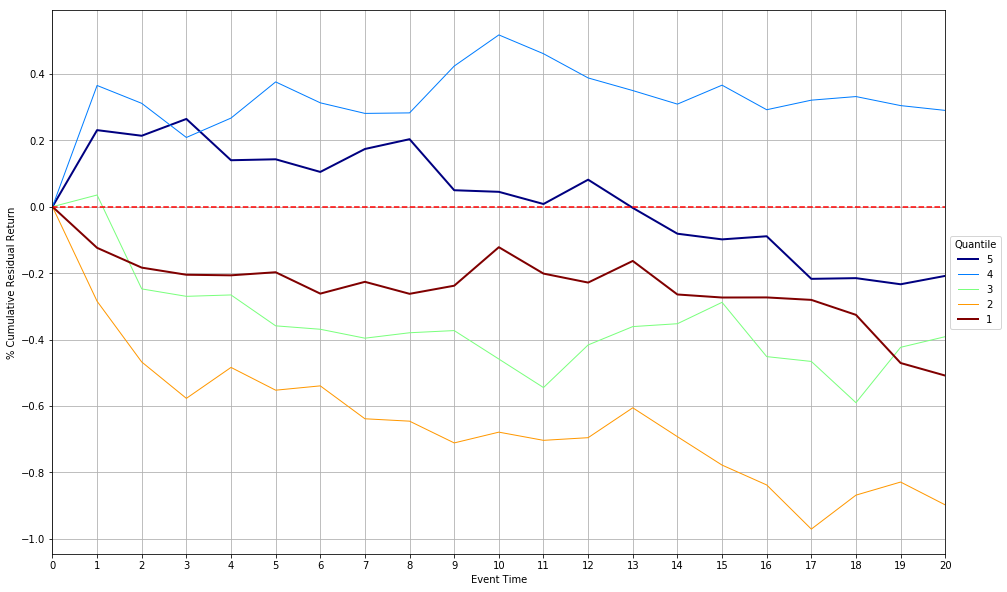

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.12%,-0.18%,-0.20%,-0.21%,-0.20%,-0.12%,-0.27%,-0.51%
2.0,-0.28%,-0.47%,-0.58%,-0.48%,-0.55%,-0.68%,-0.78%,-0.90%
3.0,0.04%,-0.25%,-0.27%,-0.27%,-0.36%,-0.46%,-0.29%,-0.39%
4.0,0.37%,0.31%,0.21%,0.27%,0.38%,0.52%,0.37%,0.29%
5.0,0.23%,0.21%,0.26%,0.14%,0.14%,0.04%,-0.10%,-0.21%


In [23]:
display_results(es2013, 'All Stocks (2013)')

In [24]:
# Run 2012 event study

start_date = '2012-01-01'
end_date = '2013-01-01'

es2012 = run_event_study(start_date, end_date)

### All Stocks (2012)

Num Events: 988


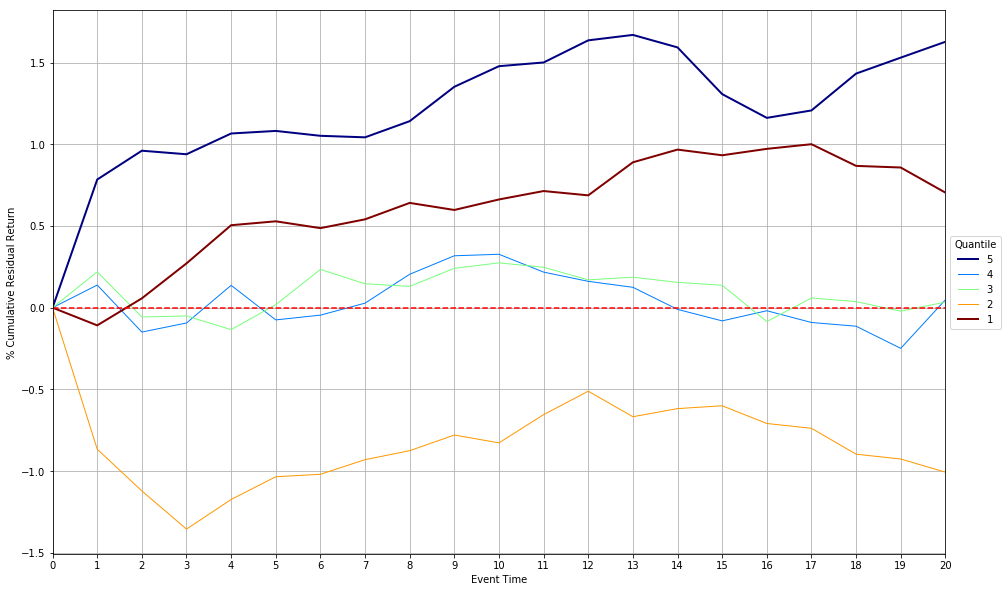

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.11%,0.06%,0.27%,0.50%,0.53%,0.66%,0.93%,0.70%
2.0,-0.87%,-1.12%,-1.36%,-1.17%,-1.03%,-0.83%,-0.60%,-1.01%
3.0,0.22%,-0.06%,-0.05%,-0.13%,0.02%,0.27%,0.14%,0.03%
4.0,0.14%,-0.15%,-0.09%,0.14%,-0.07%,0.33%,-0.08%,0.05%
5.0,0.78%,0.96%,0.94%,1.07%,1.08%,1.48%,1.31%,1.63%


In [25]:
display_results(es2012, 'All Stocks (2012)')

## Sector Analysis

In [26]:
es_sectors = run_event_study(DEFAULT_START_DATE, DEFAULT_END_DATE, join_fn=join_sectors)


/Users/ilya/dev/estimize-research-py/.virtualenv/lib/python3.5/site-packages/pandas/io/pytables.py:260: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis1] [items->None]

  f(store)


### Consumer Discretionary (All-Time)

Num Events: 5,190


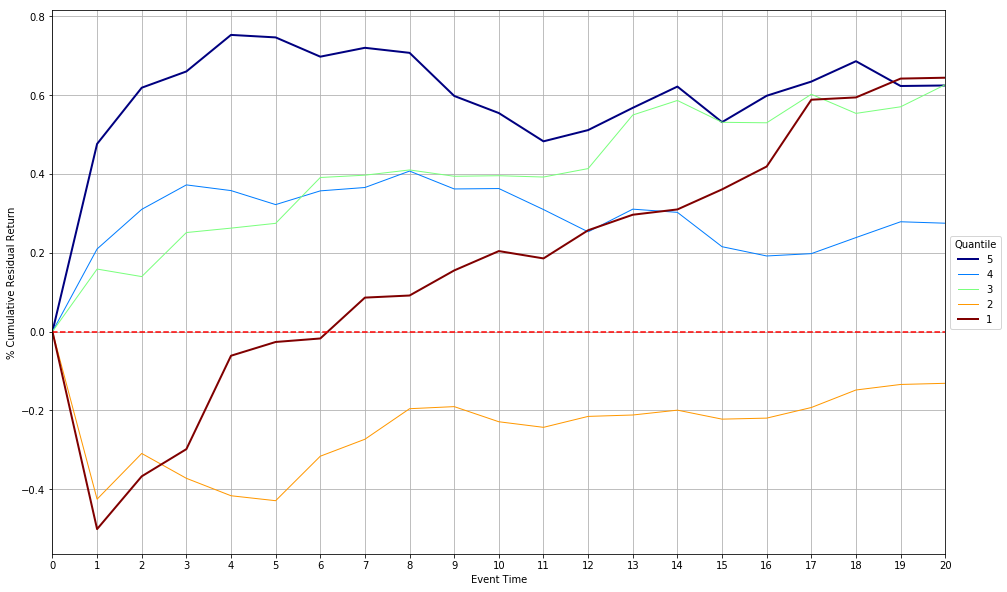

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.50%,-0.37%,-0.30%,-0.06%,-0.03%,0.20%,0.36%,0.64%
2,-0.43%,-0.31%,-0.37%,-0.42%,-0.43%,-0.23%,-0.22%,-0.13%
3,0.16%,0.14%,0.25%,0.26%,0.27%,0.40%,0.53%,0.63%
4,0.21%,0.31%,0.37%,0.36%,0.32%,0.36%,0.22%,0.28%
5,0.48%,0.62%,0.66%,0.75%,0.75%,0.55%,0.53%,0.62%


### Consumer Staples (All-Time)

Num Events: 1,458


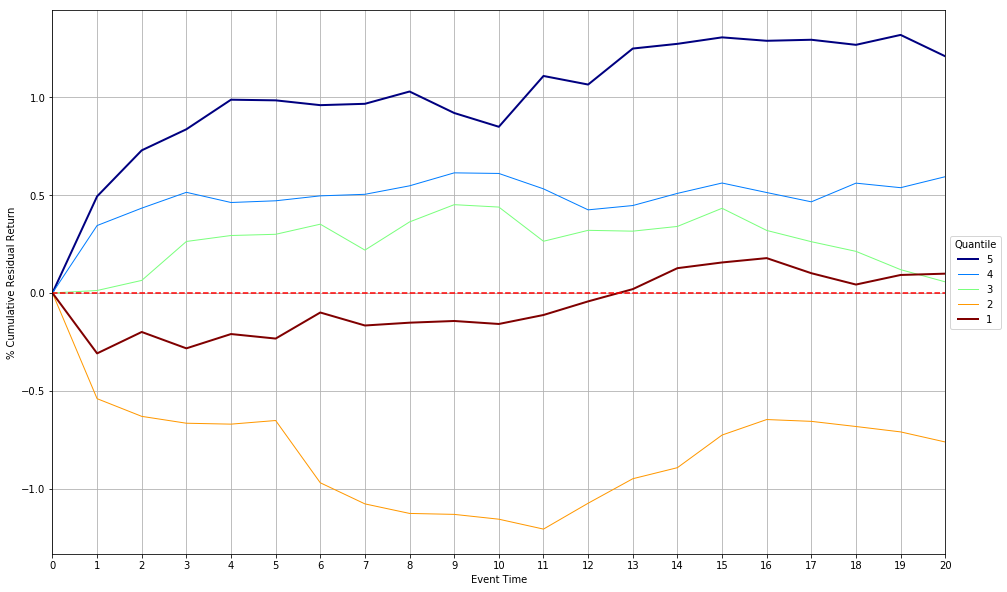

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.31%,-0.20%,-0.28%,-0.21%,-0.23%,-0.16%,0.16%,0.10%
2,-0.54%,-0.63%,-0.67%,-0.67%,-0.65%,-1.16%,-0.73%,-0.76%
3,0.01%,0.06%,0.26%,0.29%,0.30%,0.44%,0.43%,0.06%
4,0.34%,0.43%,0.51%,0.46%,0.47%,0.61%,0.56%,0.59%
5,0.49%,0.73%,0.84%,0.99%,0.98%,0.85%,1.31%,1.21%


### Energy (All-Time)

Num Events: 1,368


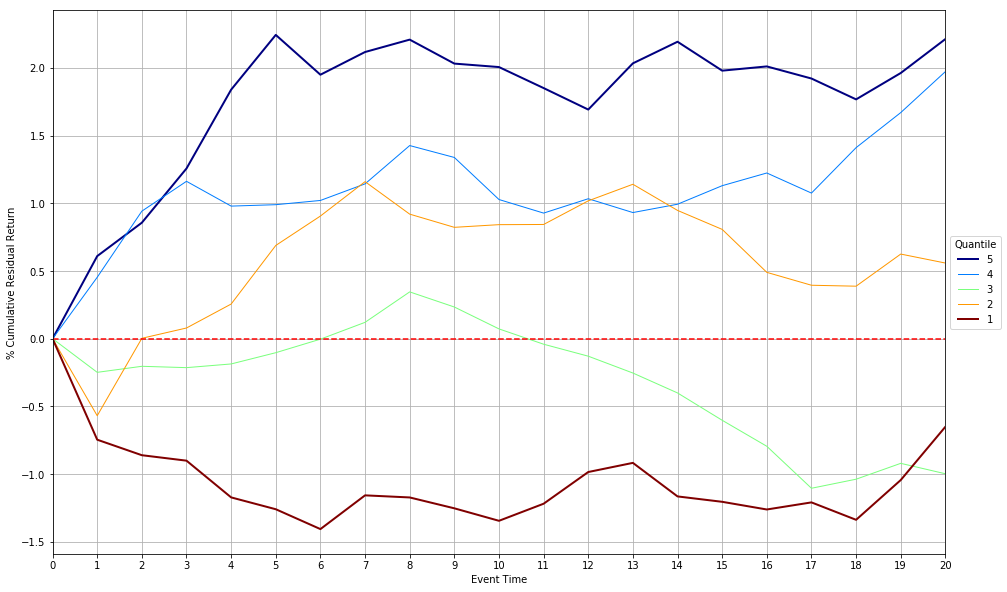

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.75%,-0.86%,-0.90%,-1.17%,-1.26%,-1.35%,-1.20%,-0.65%
2,-0.57%,0.00%,0.08%,0.26%,0.69%,0.84%,0.81%,0.56%
3,-0.25%,-0.20%,-0.21%,-0.19%,-0.10%,0.07%,-0.60%,-1.00%
4,0.45%,0.94%,1.16%,0.98%,0.99%,1.03%,1.13%,1.97%
5,0.61%,0.86%,1.26%,1.84%,2.24%,2.01%,1.98%,2.21%


### Financials (All-Time)

Num Events: 1,651


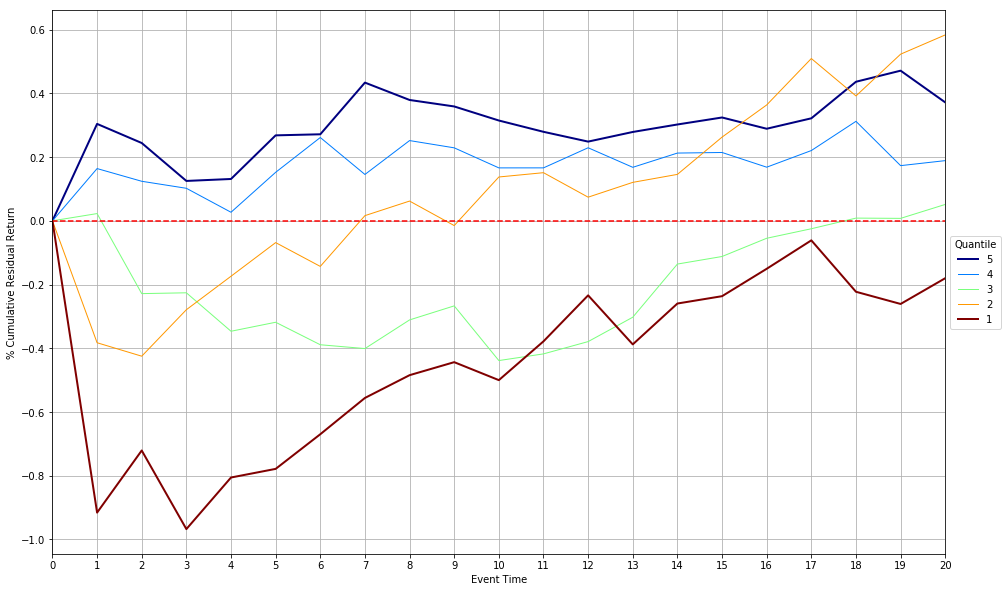

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.92%,-0.72%,-0.97%,-0.81%,-0.78%,-0.50%,-0.24%,-0.18%
2,-0.38%,-0.42%,-0.28%,-0.17%,-0.07%,0.14%,0.26%,0.58%
3,0.02%,-0.23%,-0.23%,-0.35%,-0.32%,-0.44%,-0.11%,0.05%
4,0.16%,0.12%,0.10%,0.03%,0.15%,0.17%,0.21%,0.19%
5,0.30%,0.24%,0.13%,0.13%,0.27%,0.31%,0.32%,0.37%


### Health Care (All-Time)

Num Events: 3,196


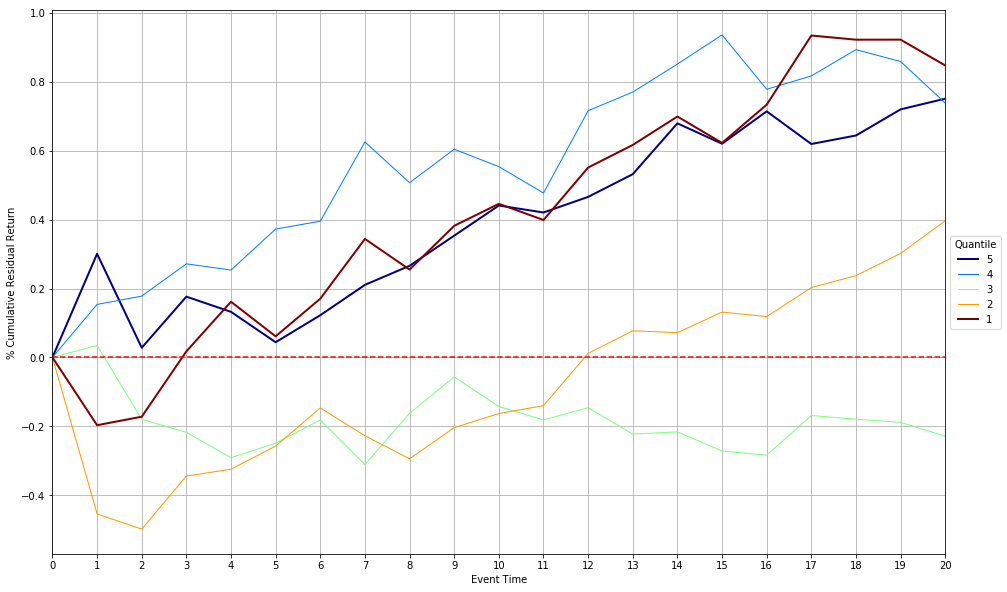

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.20%,-0.17%,0.02%,0.16%,0.06%,0.45%,0.62%,0.85%
2,-0.45%,-0.50%,-0.34%,-0.32%,-0.26%,-0.16%,0.13%,0.40%
3,0.03%,-0.18%,-0.22%,-0.29%,-0.25%,-0.14%,-0.27%,-0.23%
4,0.15%,0.18%,0.27%,0.25%,0.37%,0.55%,0.94%,0.74%
5,0.30%,0.03%,0.18%,0.13%,0.04%,0.44%,0.62%,0.75%


### Industrials (All-Time)

Num Events: 4,271


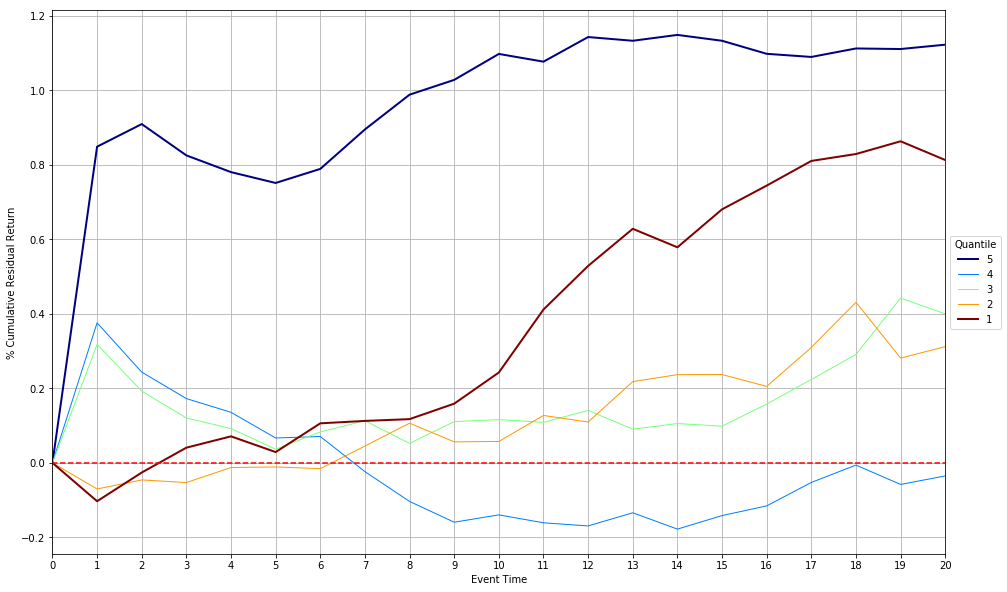

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.10%,-0.03%,0.04%,0.07%,0.03%,0.24%,0.68%,0.81%
2,-0.07%,-0.05%,-0.05%,-0.01%,-0.01%,0.06%,0.24%,0.31%
3,0.32%,0.19%,0.12%,0.09%,0.04%,0.12%,0.10%,0.40%
4,0.38%,0.24%,0.17%,0.14%,0.07%,-0.14%,-0.14%,-0.03%
5,0.85%,0.91%,0.82%,0.78%,0.75%,1.10%,1.13%,1.12%


### Information Technology (All-Time)

Num Events: 5,611


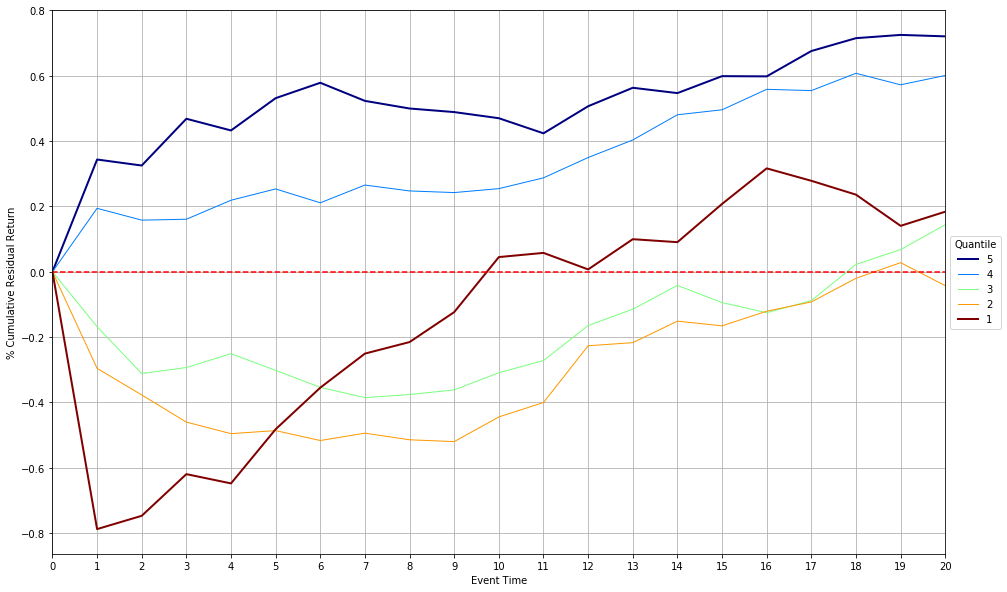

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.79%,-0.75%,-0.62%,-0.65%,-0.48%,0.04%,0.21%,0.18%
2,-0.30%,-0.38%,-0.46%,-0.50%,-0.49%,-0.44%,-0.17%,-0.04%
3,-0.17%,-0.31%,-0.29%,-0.25%,-0.30%,-0.31%,-0.09%,0.14%
4,0.19%,0.16%,0.16%,0.22%,0.25%,0.25%,0.50%,0.60%
5,0.34%,0.32%,0.47%,0.43%,0.53%,0.47%,0.60%,0.72%


### Materials (All-Time)

Num Events: 1,469


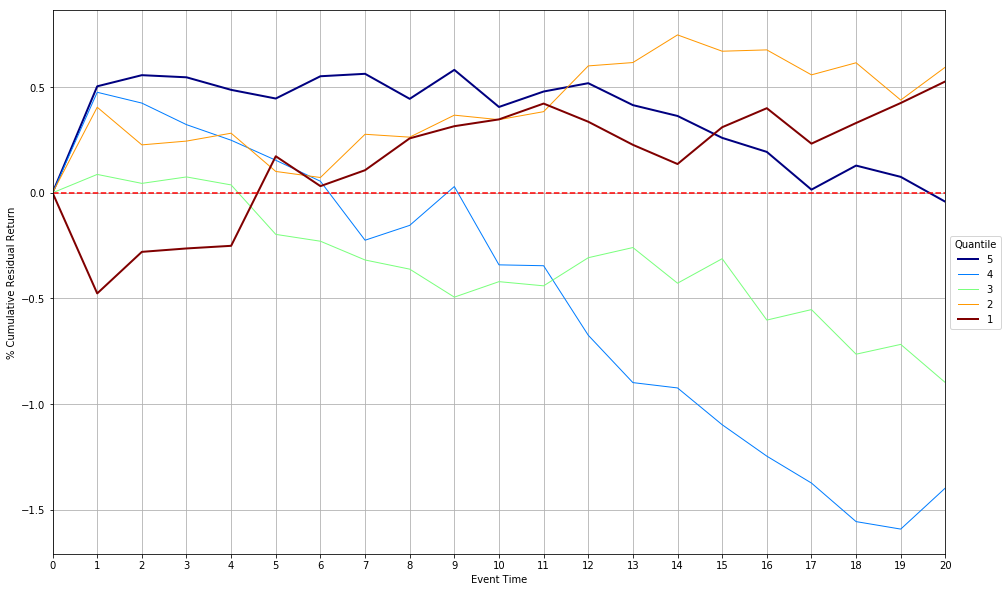

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.48%,-0.28%,-0.26%,-0.25%,0.17%,0.35%,0.31%,0.53%
2,0.40%,0.23%,0.24%,0.28%,0.10%,0.35%,0.67%,0.59%
3,0.09%,0.04%,0.08%,0.04%,-0.20%,-0.42%,-0.31%,-0.90%
4,0.48%,0.42%,0.32%,0.25%,0.15%,-0.34%,-1.10%,-1.40%
5,0.50%,0.56%,0.55%,0.49%,0.45%,0.41%,0.26%,-0.04%


### Telecommunication Services (All-Time)

Num Events: 289


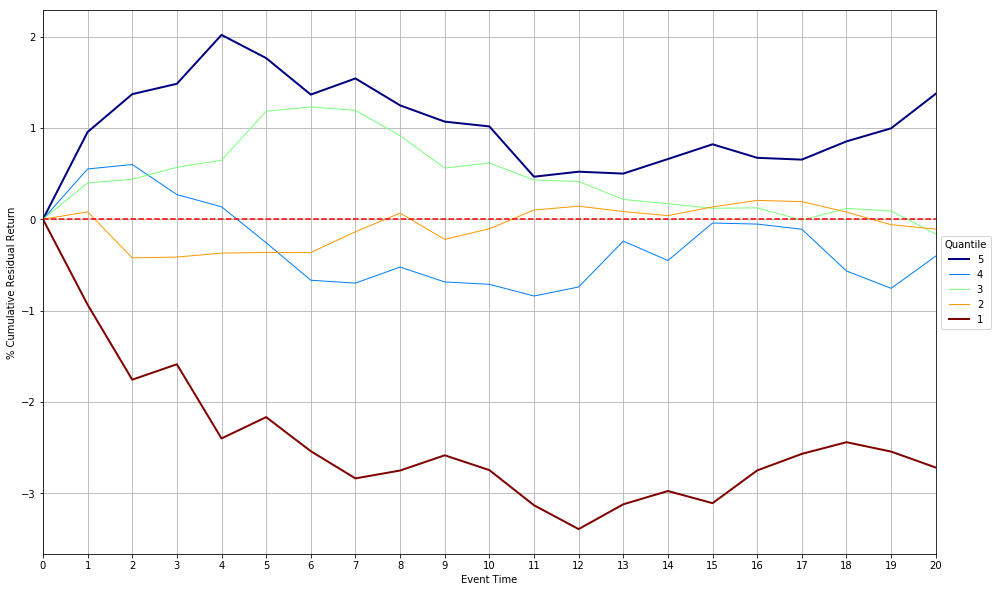

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.94%,-1.76%,-1.59%,-2.40%,-2.17%,-2.75%,-3.11%,-2.72%
2,0.08%,-0.42%,-0.41%,-0.37%,-0.36%,-0.10%,0.13%,-0.11%
3,0.40%,0.44%,0.57%,0.65%,1.18%,0.62%,0.12%,-0.16%
4,0.55%,0.60%,0.27%,0.14%,-0.26%,-0.71%,-0.04%,-0.40%
5,0.95%,1.37%,1.48%,2.02%,1.76%,1.02%,0.82%,1.37%


### Utilities (All-Time)

Num Events: 684


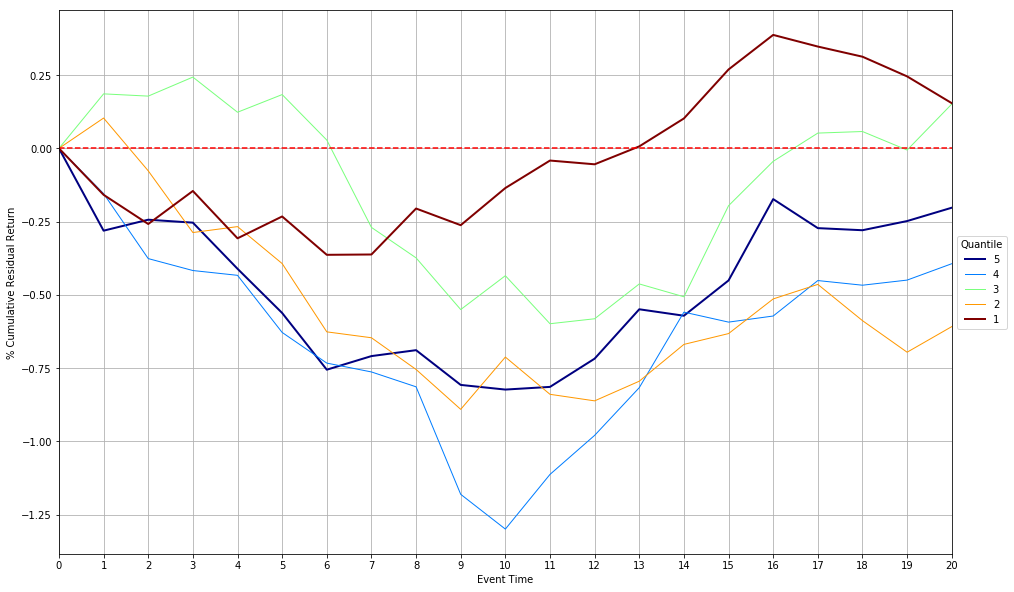

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.16%,-0.26%,-0.15%,-0.31%,-0.23%,-0.14%,0.27%,0.15%
2,0.10%,-0.08%,-0.29%,-0.27%,-0.39%,-0.71%,-0.63%,-0.61%
3,0.19%,0.18%,0.24%,0.12%,0.18%,-0.43%,-0.20%,0.15%
4,-0.15%,-0.38%,-0.42%,-0.43%,-0.63%,-1.30%,-0.59%,-0.39%
5,-0.28%,-0.24%,-0.25%,-0.41%,-0.56%,-0.82%,-0.45%,-0.20%


In [27]:
sectors = dfutils.column_values(es_sectors[0], 'sector').unique().tolist()

for sector in sectors:
    sdf = es_sectors[0]
    sdf = filter(sdf, 'sector', sector)
    display_results((sdf, None), '{} (All-Time)'.format(sector))


## Market Cap Analysis

In [28]:
es_market_caps = run_event_study(DEFAULT_START_DATE, DEFAULT_END_DATE, join_fn=join_market_caps)


/Users/ilya/dev/estimize-research-py/.virtualenv/lib/python3.5/site-packages/pandas/io/pytables.py:255: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis1_level1] [items->None]

  f = lambda store: store.put(key, value, **kwargs)


### Micro Cap (All-Time)

Num Events: 378


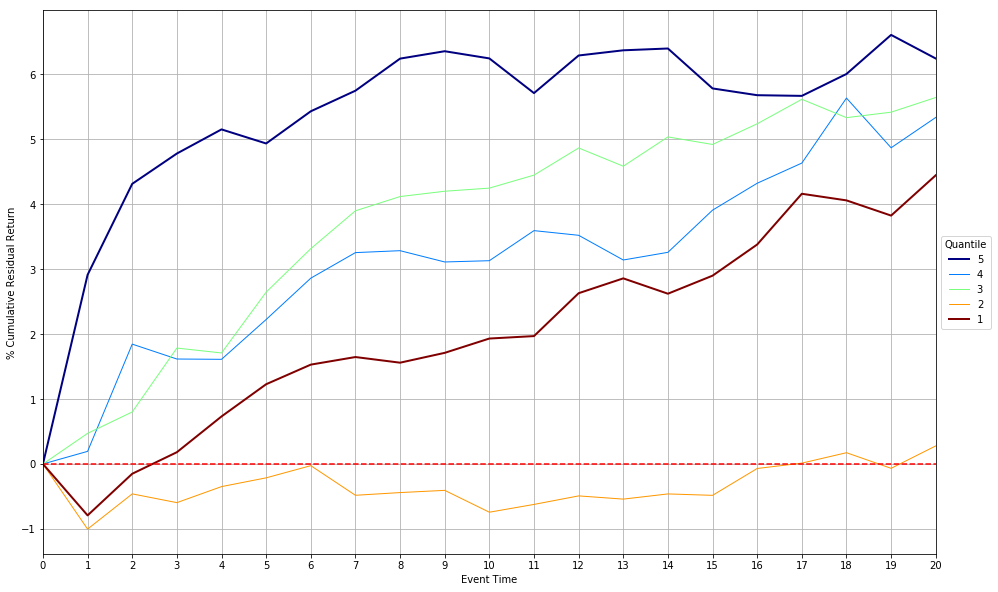

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.79%,-0.15%,0.18%,0.73%,1.23%,1.93%,2.90%,4.45%
2,-1.00%,-0.46%,-0.60%,-0.35%,-0.21%,-0.74%,-0.48%,0.28%
3,0.47%,0.80%,1.78%,1.71%,2.65%,4.25%,4.92%,5.64%
4,0.19%,1.85%,1.62%,1.61%,2.22%,3.13%,3.91%,5.34%
5,2.91%,4.31%,4.78%,5.15%,4.94%,6.25%,5.78%,6.24%


### Small Cap (All-Time)

Num Events: 7,406


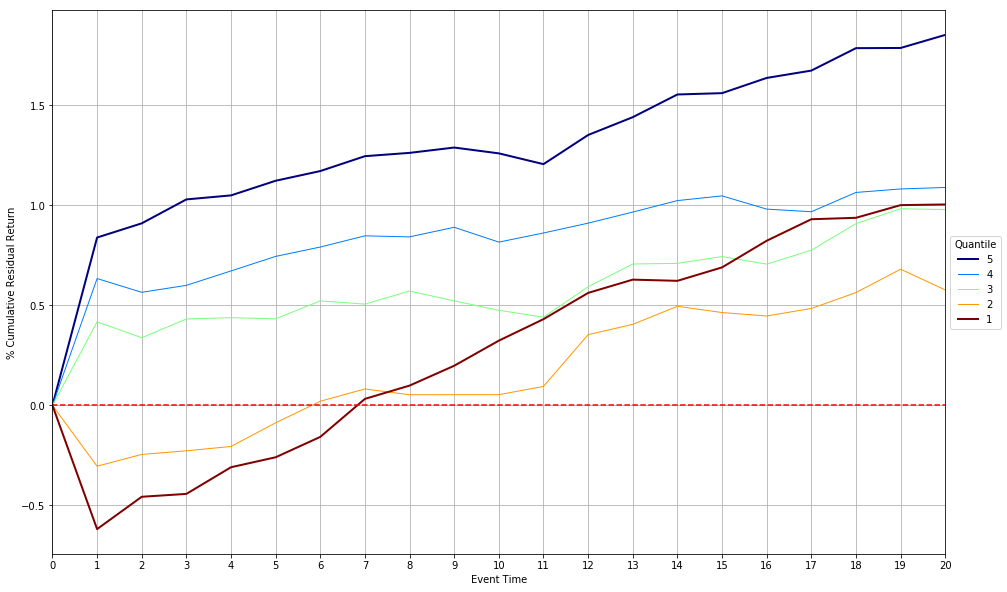

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.62%,-0.46%,-0.44%,-0.31%,-0.26%,0.32%,0.69%,1.00%
2,-0.30%,-0.25%,-0.23%,-0.21%,-0.09%,0.05%,0.46%,0.58%
3,0.42%,0.34%,0.43%,0.44%,0.43%,0.48%,0.74%,0.98%
4,0.63%,0.56%,0.60%,0.67%,0.74%,0.82%,1.05%,1.09%
5,0.84%,0.91%,1.03%,1.05%,1.12%,1.26%,1.56%,1.85%


### Mid Cap (All-Time)

Num Events: 8,804


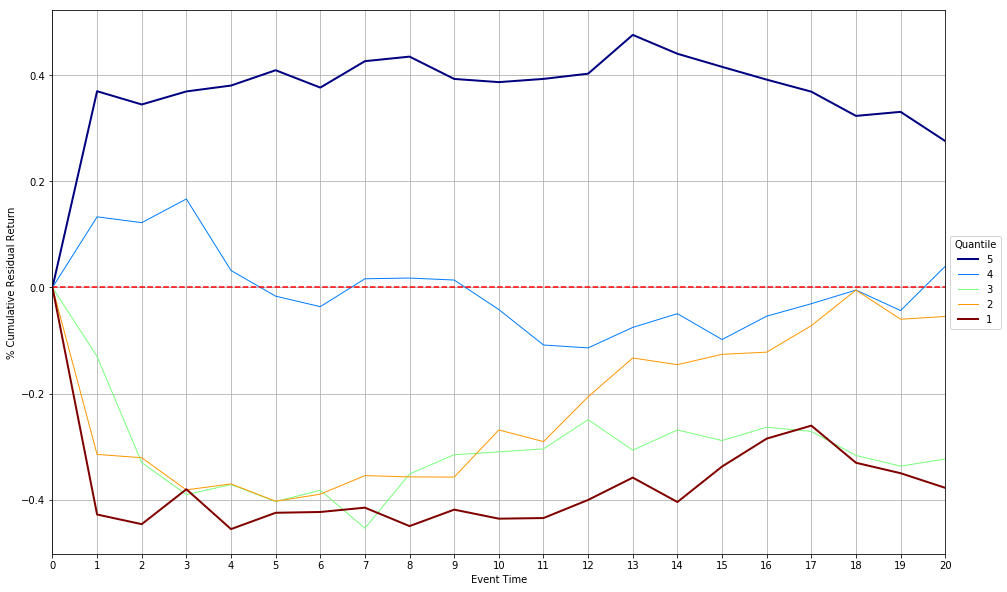

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.43%,-0.45%,-0.38%,-0.46%,-0.42%,-0.44%,-0.34%,-0.38%
2,-0.31%,-0.32%,-0.38%,-0.37%,-0.40%,-0.27%,-0.13%,-0.05%
3,-0.13%,-0.33%,-0.39%,-0.37%,-0.40%,-0.31%,-0.29%,-0.32%
4,0.13%,0.12%,0.17%,0.03%,-0.02%,-0.04%,-0.10%,0.04%
5,0.37%,0.35%,0.37%,0.38%,0.41%,0.39%,0.42%,0.28%


### Large Cap (All-Time)

Num Events: 6,608


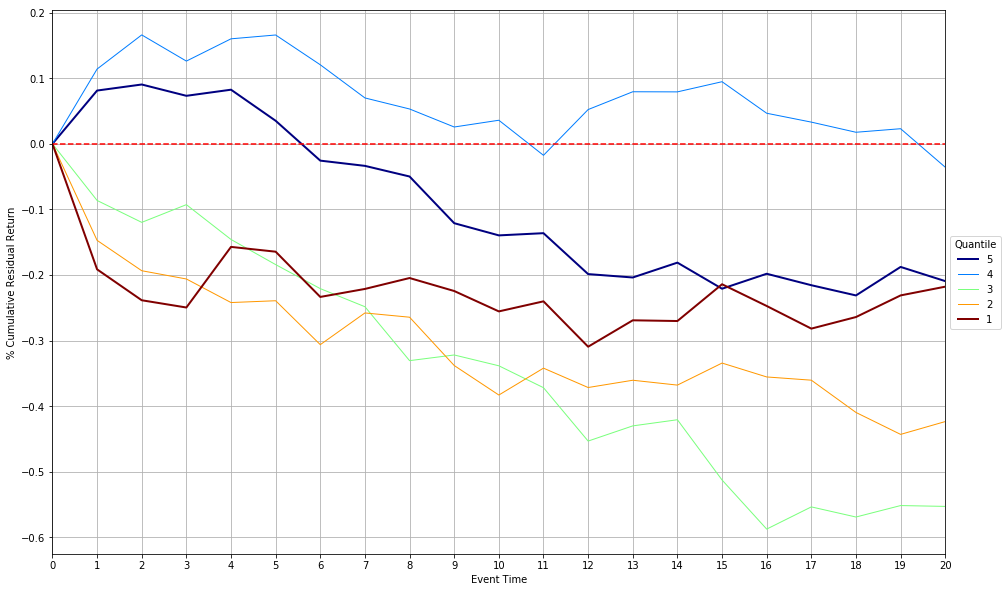

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.19%,-0.24%,-0.25%,-0.16%,-0.16%,-0.26%,-0.21%,-0.22%
2,-0.15%,-0.19%,-0.21%,-0.24%,-0.24%,-0.38%,-0.33%,-0.42%
3,-0.09%,-0.12%,-0.09%,-0.15%,-0.18%,-0.34%,-0.51%,-0.55%
4,0.11%,0.17%,0.13%,0.16%,0.17%,0.04%,0.09%,-0.04%
5,0.08%,0.09%,0.07%,0.08%,0.04%,-0.14%,-0.22%,-0.21%


### Mega Cap (All-Time)

Num Events: 277


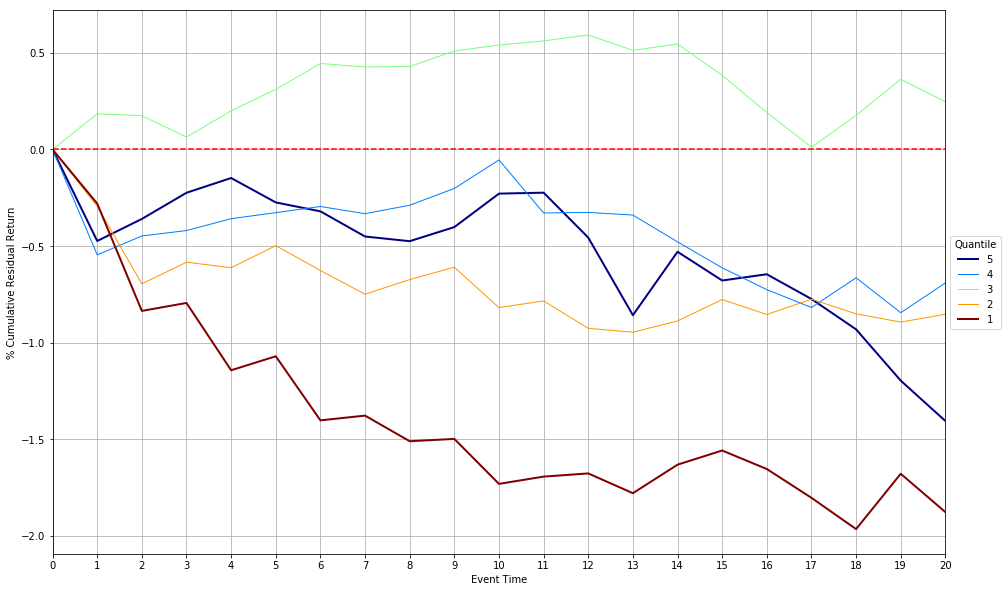

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.28%,-0.84%,-0.79%,-1.14%,-1.07%,-1.73%,-1.56%,-1.88%
2,-0.29%,-0.70%,-0.58%,-0.61%,-0.50%,-0.82%,-0.78%,-0.85%
3,0.18%,0.18%,0.06%,0.20%,0.31%,0.54%,0.38%,0.25%
4,-0.55%,-0.45%,-0.42%,-0.36%,-0.33%,-0.05%,-0.61%,-0.69%
5,-0.47%,-0.36%,-0.22%,-0.15%,-0.27%,-0.23%,-0.68%,-1.41%


In [29]:
market_cap_types = ['Micro', 'Small', 'Mid', 'Large', 'Mega']

for market_cap_type in market_cap_types:
    mdf = es_market_caps[0]
    mdf = filter(mdf, 'market_cap_type', market_cap_type)
    display_results((mdf, None), '{} Cap (All-Time)'.format(market_cap_type))
